In [1]:
import numpy as np
import h5py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
import nengolib
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, meg_from_spikes
from nengo_learn_assoc_mem.utils import BasicVecFeed
from nengo_learn_assoc_mem.learning_rules.rec_adapt import RecAdapt

from collections import namedtuple
import random

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dt = 0.001

In [3]:
dimensions = 32
n_neurons = 1000
seed = 7
n_items = 16
p_n = 0.1

In [43]:
vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, \
foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [44]:
fan_vecs = np.concatenate((fan1_pair_vecs, fan2_pair_vecs))

In [45]:
simi = np.dot(fan_vecs, fan_vecs.T)
np.fill_diagonal(simi, 0)
max_simi = np.max(simi)
max_simi

0.594983018701653

# Train Voja

In [55]:
t_present = 0.1
t_pause = 0.0
t_each = t_present + t_pause
n_repeats = 10

voja_learn_rate = 2e-4

In [56]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs
random.shuffle(feed_vecs)

In [57]:
intercepts = 0.05*np.ones(n_neurons)
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    learning = nengo.Node(lambda t: -feed.paused)
    
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, neuron_type=nengo.LIF())

    in_conn = nengo.Connection(in_nd, ens, learning_rule_type=nengo.Voja(voja_learn_rate), synapse=None)
    nengo.Connection(learning, in_conn.learning_rule, synapse=None)

    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.05)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:02.                                                   
Simulating finished in 0:00:34.                                                 


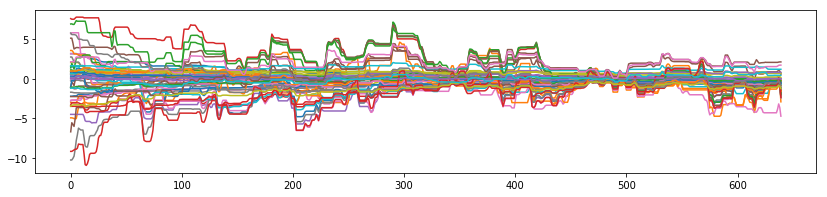

In [58]:
plt.figure(figsize=(14, 3))
plt.plot(sim.data[p_enc][:, :50, 0]);

## Save encoders

In [ ]:
with h5py.File("../data/rec_adapt/slow_voja_encoders.h5") as fi:
    enc_dat = fi.dataset("enc", data=sim.data[p_enc])
    enc_dat.attrs["repeats"] = n_repeats
    enc_dat.attrs["learning_rate"] = voja_learn_rate
    enc_dat.attrs["t_present"] = t_present
    enc_dat.attrs["t_pause"] = t_pause
    fi.dataset("intercepts", data=intercepts)

In [59]:
enc = sim.data[p_enc][-1].copy()

# Train Recurrent Adaptation

In [60]:
t_present = 0.3
t_pause = 0.5
t_each = t_pause + t_present

max_rec_inhib = -0.1
adapt_lr = -1e-3
rec_synapse = 0.05
theta_tau = 0.01

n_repeats = 1

In [61]:
fan1_slc = slice(int(t_pause/dt), int(t_each/dt)*len(fan1_pair_vecs)+int(t_pause/dt))
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+int(t_each/dt)*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+int(t_each/dt)*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+int(t_each/dt)*len(foil2_pair_vecs))

In [62]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, fan1_slc),
                 "fan2": SlcStim(2, True, fan2_slc),
                 "foil1": SlcStim(1, False, foil1_slc),
                 "foil2": SlcStim(2, False, foil2_slc)}

In [63]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

In [64]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    learning = nengo.Node(lambda t: 1-feed.paused)
    
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=enc, intercepts=intercepts)
    rec_learn = RecAdapt(n_neurons, np.zeros(n_neurons), learning_rate=(adapt_lr / n_repeats),
                         max_inhib=max_rec_inhib, theta_tau=theta_tau)

    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, rec_learn.in_neurons, synapse=rec_synapse)
    nengo.Connection(learning, rec_learn.enable, synapse=None)
    # Note: trying to inhibit the neurons when not learning has minimal effect on their decay
    nengo.Connection(rec_learn.output, ens.neurons, synapse=None)

    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:19.                                                 


In [65]:
sim.data[p_spikes].shape

(26100, 1000)

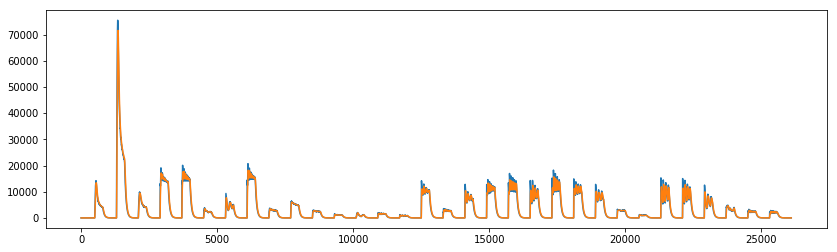

In [66]:
win = 20

theta_tau_filt = nengo.Lowpass(theta_tau)
rec_filt = nengo.Lowpass(rec_synapse)

plt.figure(figsize=(14, 4))
plt.plot(np.sum(rec_filt.filt(sim.data[p_spikes]), axis=1));
plt.plot(np.sum(theta_tau_filt.filt(rec_filt.filt(sim.data[p_spikes])), axis=1));

In [67]:
train_meg = meg_from_spikes(sim.data[p_spikes], 0.1)

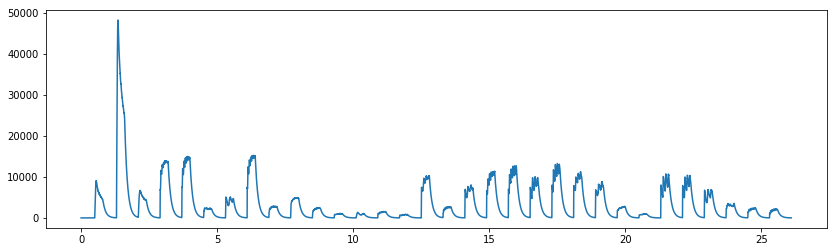

In [68]:
plt.figure(figsize=(14, 4))
plt.plot(sim.trange(), train_meg)

## Save recurrent transform

In [69]:
rw_hist = np.array(rec_learn.weight_history)

In [70]:
low_idx = np.argsort(rw_hist[-1, :])
low_idx.shape

(1000,)

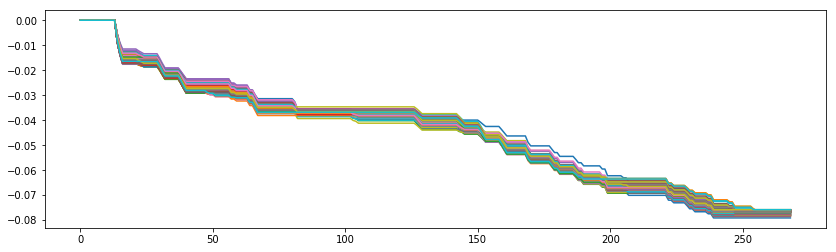

In [71]:
plt.figure(figsize=(14, 4))
#plt.plot(rw_hist[:, low_idx][:, -100:]);
#plt.plot(rw_hist[:, low_idx][:, 250:300]);
plt.plot(rw_hist[:, low_idx][:, :100]);

In [72]:
rec_w = rec_learn.weight_history[-1].copy()

## Test network on all pairs

In [73]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

In [74]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as base_model:
    in_nd = nengo.Node(feed.feed)

    ens = nengo.Ensemble(n_neurons, dimensions, encoders=enc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(base_model) as base_sim:
    base_sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:27.                                                 


In [75]:
base_meg = meg_from_spikes(base_sim.data[p_spikes])

In [76]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as learned_model:
    in_nd = nengo.Node(feed.feed)

    rec_transform = nengo.Node(lambda t, x: x * rec_w, size_in=n_neurons)
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=enc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, rec_transform, synapse=rec_synapse)
    nengo.Connection(rec_transform, ens.neurons, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(learned_model) as learned_sim:
    learned_sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:20.                                                 


In [77]:
meg_resp = meg_from_spikes(learned_sim.data[p_spikes])

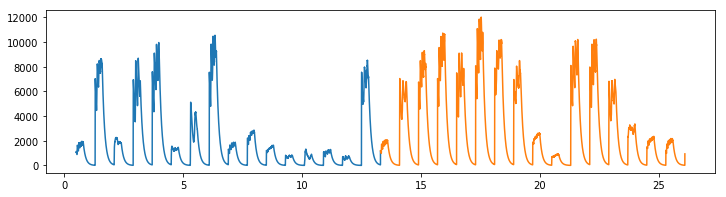

In [78]:
plt.figure(figsize=(12, 3))
plt.plot(learned_sim.trange()[fan1_slc], meg_resp[fan1_slc])
#plt.plot(base_sim.trange()[fan1_slc], base_meg[fan1_slc])
plt.plot(learned_sim.trange()[fan2_slc], meg_resp[fan2_slc])
#plt.plot(base_sim.trange()[fan2_slc], base_meg[fan2_slc])

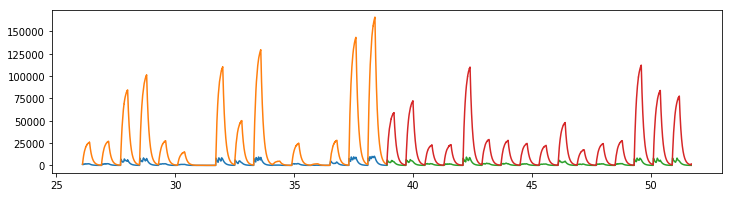

In [79]:
plt.figure(figsize=(12, 3))
plt.plot(learned_sim.trange()[foil1_slc], meg_resp[foil1_slc])
plt.plot(base_sim.trange()[foil1_slc], base_meg[foil1_slc])
plt.plot(learned_sim.trange()[foil2_slc], meg_resp[foil2_slc])
plt.plot(base_sim.trange()[foil2_slc], base_meg[foil2_slc])

In [80]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = base_meg[obj.slc] - meg_resp[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

diff_df = pd.concat(df_list)

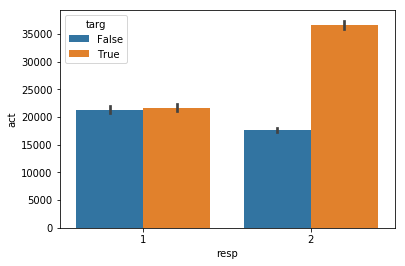

In [81]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=diff_df)

In [82]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = meg_resp[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

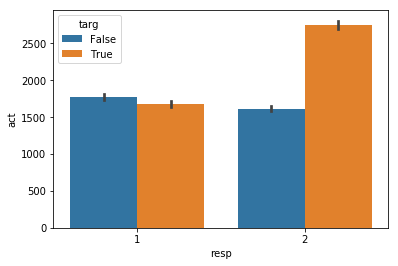

In [83]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)

# Test Association